In [7]:
using LifeSimulator, GLMakie, BenchmarkTools, PythonCall, Accessors, Dates
GLMakie.activate!(inline = true)
const LS = LifeSimulator
include("../read_model.jl")

LifeSimulator

In [8]:
model = LifelibBasiclife()
sizes = [10, 100, 1_000, 10_000]
files = "basic_term/" .* ["model_point_table_10.csv", "model_point_table_100.csv", "model_point_table_1K.csv", "model_point_table_10K.csv"]
iterative_timings = Float64[]
memoized_timings = Float64[]
for file in files
  policies = policies_from_csv(file)

  push!(iterative_timings, minimum(@benchmark CashFlow(Simulation($model, $policies), $(ntimesteps(model)))).time * 1e-9)

  set_basic_term_policies!(policies)
  push!(memoized_timings, minimum(@benchmark begin
    empty_memoization_caches!()
    sum(LS.pv_net_cf())
  end).time * 1e-9)
end

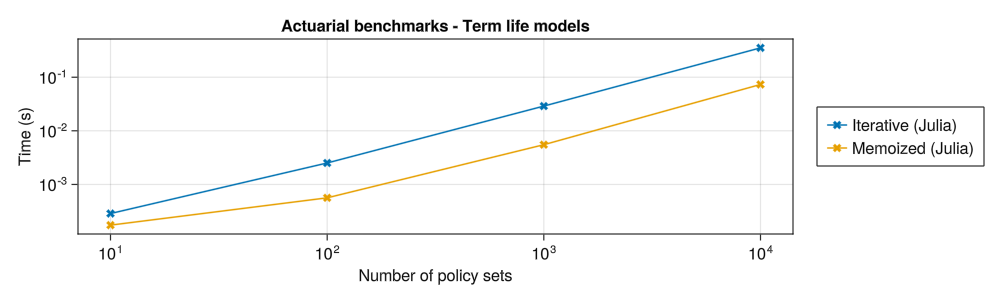

In [13]:
colors = Makie.wong_colors()
fig = Figure(; resolution = (1000, 300))
ax = Axis(fig[1, 1]; title = "Actuarial benchmarks - Term life models", xlabel = "Number of policy sets", ylabel = "Time (s)", xscale = log10, yscale = log10)
l1 = lines!(ax, sizes, iterative_timings; color = colors[1])
l2 = lines!(ax, sizes, memoized_timings; color = colors[2])
s1 = scatter!(ax, sizes, iterative_timings; color = colors[1], marker = :x)
s2 = scatter!(ax, sizes, memoized_timings; color = colors[2], marker = :x)
Legend(fig[1, 2], [[l1, s1], [l2, s2]], ["Iterative (Julia)", "Memoized (Julia)"])
fig

In [7]:
!@isdefined(proj) && (proj = read_savings_model())
proj.scen_size = 1
sizes = [9, 100, 1_000, 10_000, 100_000]
files = "savings/" .* ["model_point_table_9.csv", "model_point_table_100.csv", "model_point_table_1K.csv", "model_point_table_10K.csv", "model_point_table_100K.csv"]
julia_timings = Float64[]
python_timings = Float64[]
timeit = pyimport("timeit")
for (i, file) in enumerate(files)
  trials = Int(min(50, 3e5 ÷ sizes[i]))
  policies = policies_from_csv(file)

  # lifelib will always simulate until the largest policy term, so we make sure we have no policies beyond
  # a desired simulation end (e.g. 30 years) and at least one policy reaching such a term.
  # In this way, timesteps are consistent across evaluations with different numbers of policies.
  policies .= map(set -> @set(set.policy.issued_at = Month(0)), policies)
  policies .= map(set -> @set(set.policy.term = min(set.policy.term, Year(20))), policies)
  set = policies[1]; policies[1] = @set set.policy.term = Year(20)

  use_policies!(proj, policies)
  @assert ntimesteps(proj) == 241

  # `timeit` returns the sum of timings, so we use average timings instead of minimum timings.

  push!(julia_timings, mean(@benchmark CashFlow(sim, n) setup = begin
    policies = policies_from_csv(proj)
    n = ntimesteps(proj)
    model = LifelibSavings(investment_rates = investment_rate(proj))
    sim = Simulation(model, policies)
  end).time * 1e-9)

  push!(python_timings, pyconvert(Float64, timeit.timeit("proj.clear_cache = 1; proj.pv_net_cf().sum()"; globals = pydict(; proj), number = trials)) / trials)
end

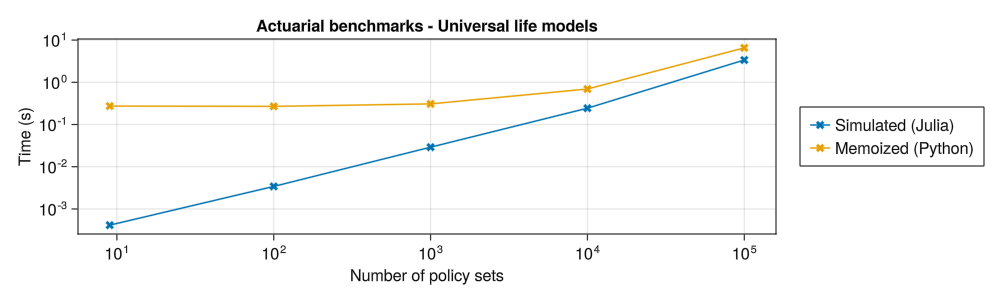

In [8]:
colors = Makie.wong_colors()
fig = Figure(; resolution = (1000, 300))
ax = Axis(fig[1, 1]; title = "Actuarial benchmarks - Universal life models", xlabel = "Number of policy sets", ylabel = "Time (s)", xscale = log10, yscale = log10)
l1 = lines!(ax, sizes, julia_timings; color = colors[1])
l2 = lines!(ax, sizes, python_timings; color = colors[2])
s1 = scatter!(ax, sizes, julia_timings; color = colors[1], marker = :x)
s2 = scatter!(ax, sizes, python_timings; color = colors[2], marker = :x)
Legend(fig[1, 2], [[l1, s1], [l2, s2]], ["Iterative (Julia)", "Memoized (Python)"])
fig